## Caution: important experiment, please do not adjust

The contents within this file are for running a publication-quality experiment and producing the associated figures and results. As such, it is finely tuned for specific high-quality graphics using the `primary.mplstyle` file. Please do not adjust. If you need to replicate results on your local system, please create a new notebook and copy contents from here.

# Landscape Detection with Generic Reconstructions

In this experiment, the ability for various reconstruction-based algorithms to rank landscapes containing novel content is investigated.

In [1]:
import sys
sys.path.append('../..')  # Expose top level program access

import time
import pickle
import logging
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from functools import reduce
from pathlib import Path

from modules.cae_base_module import CAEBaseModule
from modules.vae_base_module import VAEBaseModule
from modules.aae_base_module import AAEBaseModule
from modules.pca_base_module import PCABaseModule
from models import supported_models
from datasets import supported_datamodules
from utils import tools, metrics, supported_preprocessing_transforms
from utils.dtypes import *

logging.getLogger("matplotlib").setLevel(logging.WARNING)  # Suppress verbose font warnings from matplotlib

In [2]:
# Import configurations and paths to logged models
root = Path.cwd().parents[1]
log_path = root / 'logs' / 'LunarAnalogueDataModule'
paths_to_archived_models = list(Path(log_path).glob('**/archive_v*'))

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in paths_to_archived_models]))

Found archived models:
------
BaselineVAE/archive_v2_2021-05-06
BaselineVAE/archive_v1_2021-05-06
BaselineCAE/archive_v3_2021-05-06
BaselineCAE/archive_v2_2021-05-06
BaselineCAE/archive_v1_2021-04-12
BaselineAAE/archive_v1_2021-05-06


In [5]:
from experiments.helpers import load_modules

module_catalog, datamodule, _ = load_modules(paths_to_archived_models)

Loading state dict for: BaselineVAE/archive_v2_2021-05-06
Loading state dict for: BaselineVAE/archive_v1_2021-05-06
Loading state dict for: BaselineCAE/archive_v3_2021-05-06
Loading state dict for: BaselineCAE/archive_v2_2021-05-06
Loading state dict for: BaselineCAE/archive_v1_2021-04-12
Loading state dict for: BaselineAAE/archive_v1_2021-05-06


In [6]:
# Collect scores and labels on test set for all models and save to a dictionary
result_catalog = {}

for model_type, model_variants in module_catalog.items():
    start_time = time.time()
    
    for model_name, module in model_variants.items():
        
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        if short_name not in result_catalog:
            result_catalog[short_name] = {
                'scores': [], 
                'labels': []
            }
        print(f'------\n{short_name}\n------')
        
        # Handle the PCA and autoencoder frameworks separately
        if 'PCA' in short_name:
            test_novelty_scores = module.transform_pipeline(datamodule)
            test_novelty_labels = pca_test_labels
        else:
        
            # Set the model/components in evaluation mode
            if 'AAE' in model_type:
                module.encoder.eval()
                module.decoder.eval()
            else:
                module.model.eval()
        
            with torch.no_grad():
                for batch_nb, batch in enumerate(datamodule.test_dataloader()):

                    result = module.test_step(batch, batch_nb)

                    test_novelty_scores.extend(result['scores'])
                    test_novelty_labels.extend(result['labels'].cpu().numpy())
                    print(f'[BATCH {batch_nb}] Mean score: {np.mean(result["scores"])}')
                    
        result_catalog[short_name]['scores'] = test_novelty_scores
        result_catalog[short_name]['labels'] = test_novelty_labels
        print(f'{short_name} Time: {time.time() - start_time:.2f} s\n')

------
BaselineVAE-v2
------
[BATCH 0] Mean score: 0.645628809928894
[BATCH 1] Mean score: 0.6381195783615112
[BATCH 2] Mean score: 0.6870711445808411
[BATCH 3] Mean score: 0.674889087677002
[BATCH 4] Mean score: 0.703027069568634
[BATCH 5] Mean score: 0.654871940612793
[BATCH 6] Mean score: 0.6133604049682617
[BATCH 7] Mean score: 0.6495957970619202
[BATCH 8] Mean score: 0.7185596227645874
[BATCH 9] Mean score: 0.7159596681594849
[BATCH 10] Mean score: 0.6796066761016846
[BATCH 11] Mean score: 0.6776845455169678
[BATCH 12] Mean score: 0.6677911281585693
[BATCH 13] Mean score: 0.7070655226707458
[BATCH 14] Mean score: 0.708358883857727
[BATCH 15] Mean score: 0.6994760036468506
[BATCH 16] Mean score: 0.701107382774353
[BATCH 17] Mean score: 0.660772442817688
[BATCH 18] Mean score: 0.6723005771636963
[BATCH 19] Mean score: 0.6770370602607727
[BATCH 20] Mean score: 0.7156461477279663
[BATCH 21] Mean score: 0.7095620036125183
[BATCH 22] Mean score: 0.7048410177230835
[BATCH 23] Mean score:

BaselineVAE-v2: 568.7442016601562
BaselineVAE-v1: 583.760986328125
BaselineCAE-v3: 87.26337432861328
BaselineCAE-v2: 93.74098205566406
BaselineCAE-v1: 89.07831573486328
BaselineAAE-v1: 267.5571594238281


2021-05-19 14:03:33,891 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-05-19 14:03:33,953 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-05-19 14:03:36,159 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 14:03:36,161 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 14:03:36,162 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 14:03:36,163 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 14:03:36,164 - DEBUG - STREAM b'IDAT' 149 96
2021-05-19 14:03:36,168 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 14:03:36,168 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 14:03:36,168 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 14:03:36,168 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 14:03:36,169 - DEBUG - STREAM b'IDAT' 149 129
2021-05-19 14:03:36,171 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 14:03:36,172 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 14:03:36,172 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 14:03:36,172 - DEBUG - STREAM b'pHYs' 128 9
2021-05-

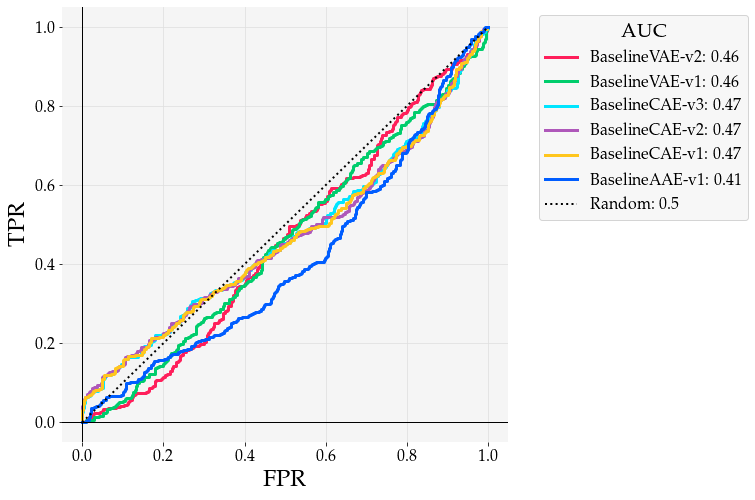

Random ROC AUC: 0.5


In [7]:
# Use standard custom styling
plt.style.use('../../utils/_extras/primary.mplstyle')

# Plot the ROC curves with AUCs for each model
fig, ax = plt.subplots(figsize=(8, 8))
for sn, results in result_catalog.items():

    scores = results['scores']
    labels = results['labels']
    print(f'{sn}: {sum(scores)}')
    
    fpr, tpr, thresholds, auc = metrics.roc(scores, labels)
    
    ax.plot(fpr, tpr, label=f'{sn}: {auc:.2f}')
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random: 0.5')
ax.legend(title='AUC', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.axhline(0, 0, c='k', lw=1)
ax.axvline(0, 0, c='k', lw=1)

plt.savefig('ROC-all_LunarAnalogueLandscape.pdf', format='pdf', bbox_inches='tight')
plt.show()
print('Random ROC AUC: 0.5')

2021-05-19 14:04:08,987 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 14:04:08,989 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 14:04:08,990 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 14:04:08,991 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 14:04:08,992 - DEBUG - STREAM b'IDAT' 149 398
2021-05-19 14:04:09,111 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 14:04:09,112 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 14:04:09,112 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 14:04:09,112 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 14:04:09,113 - DEBUG - STREAM b'IDAT' 149 156
2021-05-19 14:04:09,117 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 14:04:09,117 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 14:04:09,117 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 14:04:09,118 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 14:04:09,118 - DEBUG - STREAM b'IDAT' 149 109
2021-05-19 14:04:09,133 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 14:04:09,133 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 14:04:09,133 - DEBUG - STREAM b'tRNS' 101 15


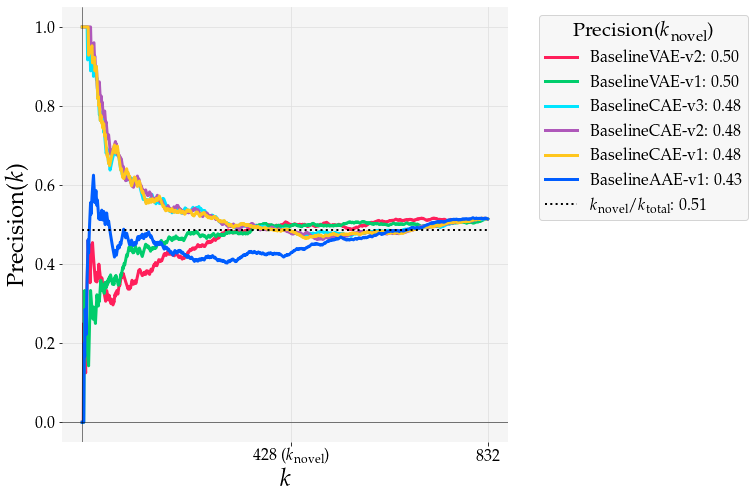

In [8]:
# Plot the Precision(k) across all test images.
fig, ax = plt.subplots(figsize=(8, 8))
for sn, results in result_catalog.items():
    
    scores = results['scores']
    labels = results['labels']
    pak = metrics.precision_at_k(scores, labels)

    uniques, counts = np.unique(labels, return_counts=True)
    random = counts.min() / counts.sum()

    ax.plot(pak, label=f'{sn}: {pak[int(sum(labels))]:.2f}')
    
ax.plot([0, len(pak)], [random, random], 'k:', lw=2, 
        label='$k_{\mathrm{novel}}/k_{\mathrm{total}}$: '+f'{counts[1]/counts.sum():.2f}')

ax.set_xlabel('$k$')
ax.set_ylabel('Precision($k$)')
ax.legend(title='Precision($k_{\mathrm{novel}}$)', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.set_xticks([counts[1], counts.sum()])
ax.set_xticklabels([str(counts[1])+' ($k_{\mathrm{novel}}$)', counts.sum()])

# Draw axes for styling
ax.axhline(0, 0, c='k', lw=0.5)
ax.axvline(0, 0, c='k', lw=0.5)

plt.savefig('Pak-all_CuriosityMastcam.pdf', format='pdf', bbox_inches='tight')
plt.show()